## 밑바닥부터 시작하는 딥러닝(Deep Learning from Scratch) 챕터별 예제코드 정리 
예제코드가 기본이나 정확히 일치하지는 않습니다. 개인적으로 모든 코드들을 문서화하되 너무 기본적인 내용은 제외하거나 나름대로 더 필요하다고 생각되는 내용은 추가하였습니다. 같은 내용을 다른 방식으로 구현하는 경우도 있습니다.
## Chapter 4. 신경망 학습
### 4.5 1-hidden layer neural net 구현 (mnist dataset)

### activation function과 loss, numerical gradient 정의

In [1]:
import numpy as np
#prerequisite
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)


def numerical_gradient(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite']) # Efficient multi-dimensional iterator object
                                                                       #  to iterate over arrays
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2 * h)

        x[idx] = tmp_val  # 값 복원
        it.iternext()
    return grad

### 하나의 hidden layer를 가진 neuralnet 구현
mnist data에 대해서 구현하므로 10가지의 숫자를 classification하는 문제이며 네트워크의 구조는 (784, 50, 10)으로 구성

In [2]:
# TwoLayerNet
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        pre_a1 = np.dot(x, W1) + b1
        a1 = sigmoid(pre_a1)
        pre_a2 = np.dot(a1, W2) + b2
        a2 = softmax(pre_a2)

        return a2

    # x : 입력데이터, t : 정답레이블
    def loss(self, x, t):
        a2 = self.predict(x)
        return cross_entropy_error(a2, t)

    def accuracy(self, x, t):
        a2 = self.predict(x)
        y = np.argmax(a2, axis = 1)
        t = np.argmax(t, axis = 1)
        accuracy = np.mean(y == t)
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}

        batch_num = x.shape[0]

        # forward
        pre_a1 = np.dot(x, W1) + b1
        a1 = sigmoid(pre_a1)
        pre_a2 = np.dot(a1, W2) + b2
        a2 = softmax(pre_a2)

        # backward
        da2 = (a2 - t) / batch_num
        grads['W2'] = np.dot(a1.T, da2)
        grads['b2'] = np.sum(da2, axis = 0)

        dpre_a1 = np.dot(da2, W2.T)
        da1 = sigmoid_grad(pre_a1) * dpre_a1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis = 0)
        return grads

In [3]:
# example1
net = TwoLayerNet(input_size = 784, hidden_size = 100, output_size = 10)
net.params['W1'].shape
net.params['b1'].shape
net.params['W2'].shape
net.params['b2'].shape

x = np.random.randn(100, 784)
y = net.predict(x) # 확률값을 반환

### Training
analytic gradient를 이용한 backprop에 대해서 앞의 notebook에서 자세한 설명은 안했지만 numerical gradient를 이용한 gradient descent로 학습하면 시간이 너무오래 걸리므로 (데이터 한개의 loss를 계산할 때, 데이터의 차원수만큼 partial gradient를 계산하는 과정이 시간이 많이걸림) 고속으로 할 수 있는 analytic gradient를 사용하여 backprop로 학습, hyper-parameter는 아래와 같음

    batch_size =100
    learning_rate = 0.1
    iter = 10000

In [4]:
# mnist dataset load
import sys, os
import pickle
import time
import matplotlib.pylab as plt
%matplotlib inline
os.chdir('C:\\Users\\KBS\\PycharmProjects\\Deep_learning_scratch')
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label = True)

In [5]:
# hyper-parameter setting
iters_num = 10**4
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
iter_per_epoch = max(train_size / batch_size, 1)

In [6]:
# save loss
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
epoch = -1

아래의 코드 블록을 실행하면 학습이 진행되며, 실제로 학습에 걸린 시간을 재어본 결과 대략 10분정도 소요되므로 아래의 코드로 학습된 neuralnet의 weight와 bias를 load

In [7]:
## network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10)
# tic_ann2 = time.clock()
# for i in range(iters_num):
#    # sample mini-batch
#    batch_mask = np.random.choice(train_size, batch_size)
#    x_batch = x_train[batch_mask]
#    t_batch = t_train[batch_mask]

#    # calculate numerical gradient
#    grad = network.gradient(x_batch, t_batch)
#
#    for key in ('W1', 'b1', 'W2', 'b2'):
#        network.params[key] -= learning_rate * grad[key]
#
#    train_loss = network.loss(x_batch, t_batch)
#    val_loss = network.loss(x_test, t_test)
#    train_loss_list.append(train_loss)
#    val_loss_list.append(val_loss)
#
#    if i % 20 == 0:
#        print('epoch = ', epoch, 'iter = ', i, 'train_loss = ', train_loss, 'val_loss = ', val_loss)
#
#    if i % iter_per_epoch == 0:
#        epoch += 1
#        train_acc = network.accuracy(x_train, t_train)
#        train_acc_list.append(train_acc)
#        val_acc = network.accuracy(x_test, t_test)
#        val_acc_list.append(val_acc)

In [8]:
# 학습된 weight와 bias
f = open('C:/Users/KBS/PycharmProjects/Deep_learning_scratch/DLFS_4_3_2.pkl', 'rb')
network = pickle.load(f)
f.close()

In [9]:
# network의 loss를 load
f = open('C:/Users/KBS/PycharmProjects/Deep_learning_scratch/DLFS_4_3_2_loss_acc.pkl', 'rb')
train_loss_list, val_loss_list, train_acc_list, val_acc_list = pickle.load(f)
f.close()

### Visualization for loss & accuracy
loss와 accuracy를 visualize 해본 결과 아직 network를 더 학습을 진행시켜야한다는 판단을 할 수 있다. (val loss와 증가하기 시작하는 시점이 val loss의 최소값) 자세한 것은 아래의 wiki link를 참고  
https://en.wikipedia.org/wiki/Overfitting

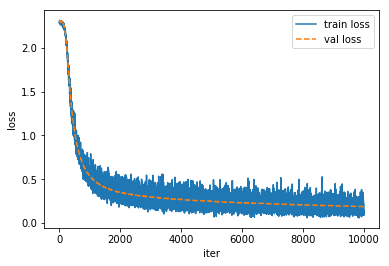

In [10]:
# visualization for loss
# 그래프 그리기
# loss
x = np.arange(len(train_loss_list))
plt.plot(x,train_loss_list, label = 'train loss')
plt.plot(x,val_loss_list, label = 'val loss',linestyle = '--')
plt.xlabel('iter')
plt.ylabel('loss')
plt.legend(loc = 'upper right')
plt.show()

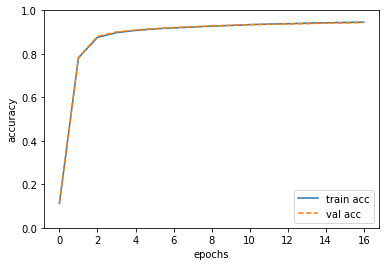

In [11]:
# accuracy
markers = {'train': 'o', 'val': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, val_acc_list, label='val acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()